<a href="https://colab.research.google.com/github/AryamanKaprekar/Practice_Collection/blob/main/merged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(torch.__version__)
print(torchvision.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2.5.1+cu121
0.20.1+cu121
Using device: cuda


In [39]:
import requests
import kagglehub
import zipfile
from pathlib import Path
import os
import shutil
from sklearn.model_selection import train_test_split

# Download dataset using kagglehub
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print(f"Path to dataset: {path}")

# Define paths for training and test sets
train_path = "/content/train"
test_path = "/content/test"

# Check if train and test sets already exist
if os.path.exists(train_path) and os.path.exists(test_path):
    print("Train and test sets already exist.")
else:
    # Create directories for training and testing sets
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Split each classification into training and test sets
    for class_name in os.listdir(path):
        class_dir = os.path.join(path, class_name)

        # Skip if not a directory
        if not os.path.isdir(class_dir):
            continue

        # List all images in the class directory
        images = os.listdir(class_dir)

        # Split into training and testing sets
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Create subdirectories for the class in train and test folders
        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

        # Move training images
        for image in train_images:
            shutil.move(os.path.join(class_dir, image), os.path.join(train_path, class_name, image))

        # Move testing images
        for image in test_images:
            shutil.move(os.path.join(class_dir, image), os.path.join(test_path, class_name, image))

    print("Dataset successfully divided into training and test sets!")

Path to dataset: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1
Train and test sets already exist.


In [40]:
transform= transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_data=datasets.ImageFolder(root=train_path, transform=transform)
test_data=datasets.ImageFolder(root=test_path, transform=transform)
print(len(train_data),len(test_data))
print(train_data.class_to_idx)
print(test_data.class_to_idx)
train_dataloader=torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

5617 1406
{'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}
{'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}


In [41]:
# Define TinyVGG as per your structure
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

# Define the hybrid model combining ResNet-18 and TinyVGG
class HybridModel(nn.Module):
    def __init__(self, output_shape: int):
        super(HybridModel, self).__init__()

        # Load pre-trained ResNet-18 and remove the final layers
        self.resnet = models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])  # Remove FC and avgpool layers

        # Initialize TinyVGG with matching input channels and output shape
        self.tinyvgg = TinyVGG(input_shape=512, hidden_units=128, output_shape=output_shape)

    def forward(self, x):
        # Extract features with ResNet-18
        x = self.resnet(x)

        # Interpolate to 64x64 to fit TinyVGG’s input requirements
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)

        # Pass through TinyVGG for the final classification
        x = self.tinyvgg(x)

        return x

# Instantiate the hybrid model with desired output shape
output_shape = 4 # for example, 10 classes
model = HybridModel(output_shape=output_shape).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          class_names: list[str],
          epochs: int):
    """
    Training loop for a PyTorch model with metrics (precision, recall, F1-score, confusion matrix)
    calculated only after all epochs.
    """
    results = {"train_loss": [], "train_acc": []}
    all_preds, all_labels = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Predictions
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            correct += (y_pred_class == y).sum().item()
            total += y.size(0)

            # Collect predictions and labels for metrics at the end
            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

        # Calculate loss and accuracy for the epoch
        train_acc = correct / total
        train_loss /= len(train_dataloader)

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Calculate and print average metrics after training
    print("\nEvaluating on training data after last epoch...")

    # Calculate precision, recall, and F1 score
    metrics = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    avg_precision = metrics["weighted avg"]["precision"]
    avg_recall = metrics["weighted avg"]["recall"]
    avg_f1_score = metrics["weighted avg"]["f1-score"]

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

    # Print final metrics
    print(f"Avg Precision: {avg_precision:.4f} | Avg Recall: {avg_recall:.4f} | Avg F1-Score: {avg_f1_score:.4f}")

    return results

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.3823 | Train Acc: 0.8659
Epoch 2/10 | Train Loss: 0.1794 | Train Acc: 0.9468
Epoch 3/10 | Train Loss: 0.1260 | Train Acc: 0.9626
Epoch 4/10 | Train Loss: 0.1020 | Train Acc: 0.9703
Epoch 5/10 | Train Loss: 0.0745 | Train Acc: 0.9781
Epoch 6/10 | Train Loss: 0.0485 | Train Acc: 0.9863
Epoch 7/10 | Train Loss: 0.0563 | Train Acc: 0.9826
Epoch 8/10 | Train Loss: 0.0721 | Train Acc: 0.9795
Epoch 9/10 | Train Loss: 0.0749 | Train Acc: 0.9802
Epoch 10/10 | Train Loss: 0.0360 | Train Acc: 0.9897

Evaluating on training data after last epoch...


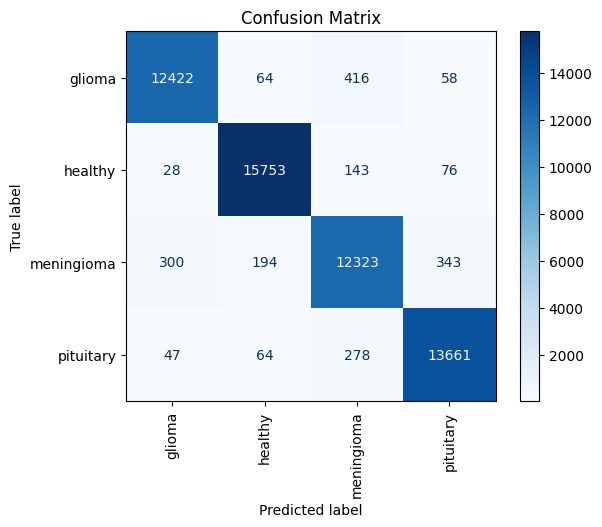

Avg Precision: 0.9642 | Avg Recall: 0.9642 | Avg F1-Score: 0.9642
Total training time 628.643 seconds


In [43]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()
class_names = train_data.classes
from timeit import default_timer as timer
start_time=timer()
train_results = train(model=model,
                      train_dataloader=train_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      class_names=class_names,
                      epochs=10)
end_time=timer()
print(f"Total training time {end_time - start_time:.3f} seconds")

In [44]:
def save_model(model: torch.nn.Module, path: str):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Example usage
model_save_path = "/content/model.pth"
save_model(model, model_save_path)

Model saved to /content/model.pth


In [45]:
from PIL import Image
import numpy as np
def load_model(model: torch.nn.Module, path: str, device="cpu"):
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    print(f"Model loaded from {path}")
    return model

# Example usage
loaded_model = load_model(model, model_save_path, device=device)
def test_and_save_images(model: torch.nn.Module,
                         dataloader: torch.utils.data.DataLoader,
                         output_folder: str,
                         class_names: list[str],
                         transform=None,
                         device=device):

    model.eval()
    os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Get predictions
            y_pred = model(X)
            y_pred_prob = torch.softmax(y_pred, dim=1)
            y_pred_class = torch.argmax(y_pred_prob, dim=1)

            # Loop through each image in the batch
            for i in range(len(X)):
                # Convert the image tensor to a NumPy array
                img = X[i].cpu().detach()

                if transform:
                    img = transform(img)

                img = img.permute(1, 2, 0).numpy()  # Convert to HxWxC format for displaying
                img = np.clip((img * 255), 0, 255).astype(np.uint8)  # Denormalize and clip the values to [0, 255]

                # Prepare the prediction title
                pred_label = class_names[y_pred_class[i].item()]
                pred_prob = y_pred_prob[i, y_pred_class[i].item()].item()
                title = f"Pred: {pred_label} | Prob: {pred_prob:.3f}"

                # Save image with title as the name
                image_filename = f"{output_folder}/image_{batch * len(X) + i}_pred_{pred_label}_prob_{pred_prob:.3f}.png"

                # Convert NumPy array to PIL image using Image.fromarray() after ensuring uint8 type
                pil_image = Image.fromarray(img)
                pil_image.save(image_filename)

    print(f"Images with predictions and probabilities saved to {output_folder}")


Model loaded from /content/model.pth


<ipython-input-45-2ac0a9557c36>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


In [46]:
output_folder = "/content/test_results"  # Folder where images will be saved
class_names = train_data.classes  # Assuming this is your class names
transform = transforms.Compose([transforms.Resize((224, 224))])  # Optional: Resize image if needed

test_and_save_images(model=loaded_model,
                     dataloader=test_dataloader,
                     output_folder=output_folder,
                     class_names=class_names,
                     transform=transform,
                     device=device)

Images with predictions and probabilities saved to /content/test_results


In [47]:
"""import shutil

# Path to the folder you want to delete
folder_path = "/content/test_results"

# Delete the folder and all its contents
shutil.rmtree(folder_path)

print(f"Folder '{folder_path}' and all its contents have been deleted.")
"""

'import shutil\n\n# Path to the folder you want to delete\nfolder_path = "/content/test_results"\n\n# Delete the folder and all its contents\nshutil.rmtree(folder_path)\n\nprint(f"Folder \'{folder_path}\' and all its contents have been deleted.")\n'

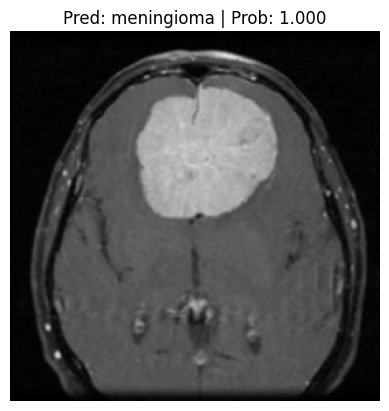

In [48]:
custom_image_path="/content/testing.png"
custom_image_transform=transforms.Compose([
    transforms.Resize(size=(224,224))
])
def pred_and_plot_image(model:torch.nn.Module,
                         image_path:str,
                         class_names:list[str]=None,
                         transform=None,
                         device=device):
  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)/255.0
  if transform:
    target_image=transform(target_image)
  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image_pred=model(target_image.unsqueeze(0).to(device))
  target_image_pred_prob=torch.softmax(target_image_pred, dim=1)
  target_image_pred_label=torch.argmax(target_image_pred_prob, dim=1)
  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title=f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_prob.max():.3f}"
  else:
    title=f"Pred: {target_image_pred_label} | Prob: {target_image_pred_prob.max():.3f}"
  plt.title(title)
  plt.axis(False)
pred_and_plot_image(model=loaded_model,
                  image_path=custom_image_path,
                  class_names=train_data.classes,
                  transform=custom_image_transform,
                  device=device)